In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

Epoch 1/10
  5/196 ━━━━━━━━━━━━━━━━━━━━ 7s 40ms/step - loss: 0.3895

W0000 00:00:1723460144.863264     106 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1723460144.866415     106 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


196/196 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.2558

W0000 00:00:1723460150.898273     108 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1723460151.563037     107 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


196/196 ━━━━━━━━━━━━━━━━━━━━ 11s 38ms/step - loss: 0.2556 - val_loss: 0.1808
Epoch 2/10
196/196 ━━━━━━━━━━━━━━━━━━━━ 5s 27ms/step - loss: 0.1741 - val_loss: 0.1650
Epoch 3/10
196/196 ━━━━━━━━━━━━━━━━━━━━ 5s 27ms/step - loss: 0.1636 - val_loss: 0.1608
Epoch 4/10
196/196 ━━━━━━━━━━━━━━━━━━━━ 5s 27ms/step - loss: 0.1597 - val_loss: 0.1582
Epoch 5/10
196/196 ━━━━━━━━━━━━━━━━━━━━ 5s 27ms/step - loss: 0.1565 - val_loss: 0.1546
Epoch 6/10
196/196 ━━━━━━━━━━━━━━━━━━━━ 5s 27ms/step - loss: 0.1539 - val_loss: 0.1526
Epoch 7/10
196/196 ━━━━━━━━━━━━━━━━━━━━ 5s 27ms/step - loss: 0.1518 - val_loss: 0.1513
Epoch 8/10
196/196 ━━━━━━━━━━━━━━━━━━━━ 5s 27ms/step - loss: 0.1504 - val_loss: 0.1499
Epoch 9/10
196/196 ━━━━━━━━━━━━━━━━━━━━ 5s 27ms/step - loss: 0.1492 - val_loss: 0.1496
Epoch 10/10
196/196 ━━━━━━━━━━━━━━━━━━━━ 5s 27ms/step - loss: 0.1485 - val_loss: 0.1486
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


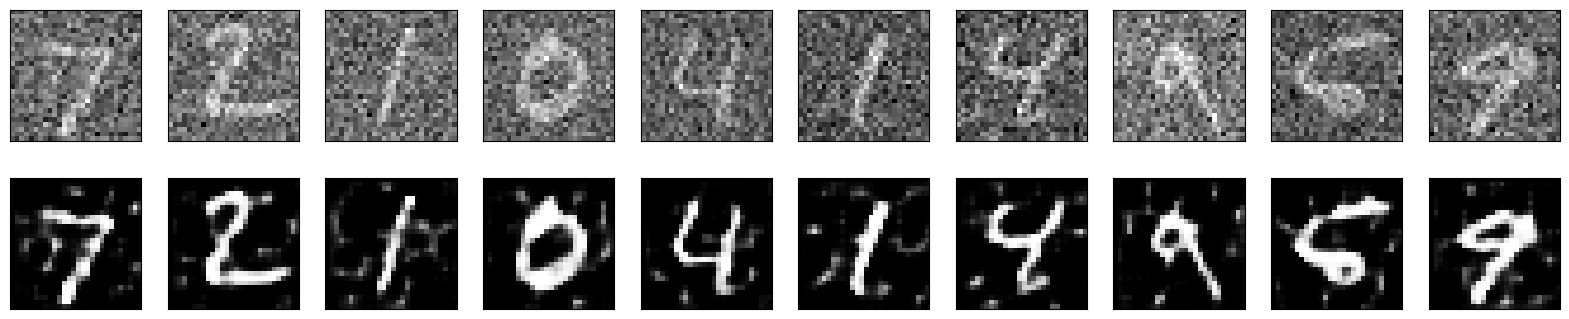

In [10]:
from typing import Tuple, Optional
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Flatten, Reshape, Conv2D, Conv2DTranspose
from tensorflow.keras.models import Model
from tensorflow.keras.datasets import mnist
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.optimizers import Adam
import numpy as np
import matplotlib.pyplot as plt

# ----------------------------------------------------------------------
# Cargar y preparar el conjunto de datos MNIST
# ----------------------------------------------------------------------
def load_and_prepare_data(scale: float = 0.4) -> Tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray, np.ndarray, np.ndarray]:
    """
    Carga el conjunto de datos MNIST, añade ruido y lo divide en conjuntos de entrenamiento, validación y prueba.

    Parámetros
    ----------
    scale : float, opcional
        La desviación estándar del ruido gaussiano añadido a las imágenes (por defecto es 0.4).

    Retorna
    -------
    Tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray, np.ndarray, np.ndarray]
        x_train: Datos de entrenamiento con forma (50000, 28, 28, 1).
        y_train: Etiquetas de entrenamiento con forma (50000,).
        x_val: Datos de validación con forma (10000, 28, 28, 1).
        y_val: Etiquetas de validación con forma (10000,).
        x_test: Datos de prueba con forma (10000, 28, 28, 1).
        y_test: Etiquetas de prueba con forma (10000,).
    """
    # Carga el conjunto de datos MNIST
    (x_train, y_train), (x_test, y_test) = mnist.load_data()
    
    # Normaliza las imágenes y añade ruido gaussiano
    x_train = x_train.astype('float32') / 255.0 + np.random.normal(scale=scale, size=x_train.shape)
    x_test = x_test.astype('float32') / 255.0 + np.random.normal(scale=scale, size=x_test.shape)
    
    # Divide el conjunto de entrenamiento en entrenamiento y validación
    x_val = x_train[50000:]  # Últimos 10,000 ejemplos para validación
    y_val = y_train[50000:]
    x_train = x_train[:50000]  # Primeros 50,000 ejemplos para entrenamiento
    y_train = y_train[:50000]
    
    # Añade una nueva dimensión para las capas convolucionales
    x_train = x_train[..., tf.newaxis]
    x_val = x_val[..., tf.newaxis]
    x_test = x_test[..., tf.newaxis]
    
    # Retorna los datos preparados
    return x_train, y_train, x_val, y_val, x_test, y_test

# ----------------------------------------------------------------------
# Función para graficar resultados del autoencoder
# ----------------------------------------------------------------------
def plot_mnist_autoencoder(autoencoder: Model, data: Tuple[np.ndarray, np.ndarray], n: int = 10) -> None:
    """
    Grafica las imágenes originales y las imágenes reconstruidas por el autoencoder.

    Parámetros
    ----------
    autoencoder : Model
        El modelo de autoencoder entrenado.
    data : Tuple[np.ndarray, np.ndarray]
        El conjunto de datos de prueba para graficar (x_test, y_test).
    n : int, opcional
        El número de imágenes a mostrar (por defecto es 10).
    """
    x_test, y_test = data  # Desempaqueta los datos de prueba
    decoded_imgs = autoencoder.predict(x_test)  # Genera las imágenes reconstruidas

    # Configura la figura de la gráfica
    plt.figure(figsize=(20, 4))
    for i in range(n):
        # Muestra las imágenes originales
        ax = plt.subplot(2, n, i + 1)
        plt.imshow(x_test[i].reshape(28, 28))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        # Muestra las imágenes reconstruidas
        ax = plt.subplot(2, n, i + 1 + n)
        plt.imshow(decoded_imgs[i].reshape(28, 28))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.show()

# ----------------------------------------------------------------------
# Definir el modelo de Autoencoder
# ----------------------------------------------------------------------
def build_autoencoder(input_shape: Tuple[int, int, int]) -> Model:
    """
    Construye y compila un modelo de autoencoder.

    Parámetros
    ----------
    input_shape : Tuple[int, int, int]
        La forma de los datos de entrada (altura, ancho, canales).

    Retorna
    -------
    Model
        El modelo de autoencoder compilado.
    """
    inputs = Input(shape=input_shape)  # Define la entrada del modelo con la forma especificada
    
    # Codificador: varias capas convolucionales con activación ReLU
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    x = Conv2D(64, (3, 3), activation='relu', padding='same', strides=(2, 2))(x)
    x = Conv2D(128, (3, 3), activation='relu', padding='same', strides=(2, 2))(x)
    x = Flatten()(x)  # Aplana la salida del codificador
    latent = Dense(128, activation='relu')(x)  # Capa densa para la representación latente
    
    # Decodificador: capas de deconvolución (Conv2DTranspose) para reconstruir la imagen
    x = Dense(7 * 7 * 128, activation='relu')(latent)
    x = Reshape((7, 7, 128))(x)
    x = Conv2DTranspose(128, (3, 3), activation='relu', strides=(2, 2), padding='same')(x)
    x = Conv2DTranspose(64, (3, 3), activation='relu', strides=(2, 2), padding='same')(x)
    outputs = Conv2DTranspose(1, (3, 3), activation='sigmoid', padding='same')(x)  # Reconstruye la imagen con una única capa de salida
    
    # Compila el modelo de autoencoder
    autoencoder = Model(inputs, outputs)
    autoencoder.compile(optimizer=Adam(), loss=MeanSquaredError())  # Usa Adam como optimizador y MSE como función de pérdida
    return autoencoder

# ----------------------------------------------------------------------
# Flujo principal de ejecución
# ----------------------------------------------------------------------
if __name__ == "__main__":
    # Cargar y preparar los datos
    x_train, y_train, x_val, y_val, x_test, y_test = load_and_prepare_data()

    # Construir el autoencoder
    autoencoder = build_autoencoder(input_shape=(28, 28, 1))

    # Entrenar el autoencoder
    autoencoder.fit(x_train, x_train, epochs=10, batch_size=256, validation_data=(x_val, x_val))

    # Graficar los resultados
    plot_mnist_autoencoder(autoencoder, (x_test, y_test))
